In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.model_selection import train_test_split, GridSearchCV
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report, make_scorer
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import tree 
from xgboost import XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier, Booster
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import plotly.express as px

sns.set_style('whitegrid')

In [6]:
import pandas as pd

# Load dataset into a Pandas dataframe
df = pd.read_csv('tripadvisor_hotel_reviews.csv')




In [7]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


# Exploratory Data **Analysis**

In [8]:
df.isna().sum()

Review    0
Rating    0
dtype: int64

Review Count Visual

Text(0.5, 1.0, 'Review Count by Rating')

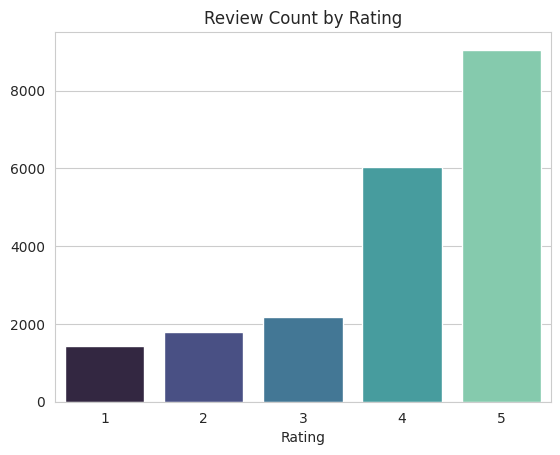

In [9]:
grouped = df.groupby('Rating')['Rating'].count()
sns.barplot(x = grouped.index, y = grouped.values, palette='mako').set_title('Review Count by Rating')

After plotting review count per rating, it is evident that there is a class imbalance. By group together ratings of 1 and 2, ratings of 3 and 4, and rating 5, the class imbalance should be reduced.

In [10]:
def new_rating(num):
    if (num == 1) or (num == 2):
        return 'poor'
    elif (num == 3) or (num == 4):
        return 'average'
    else:
        return 'excellent'

df['new_rating'] = df['Rating'].apply(new_rating)

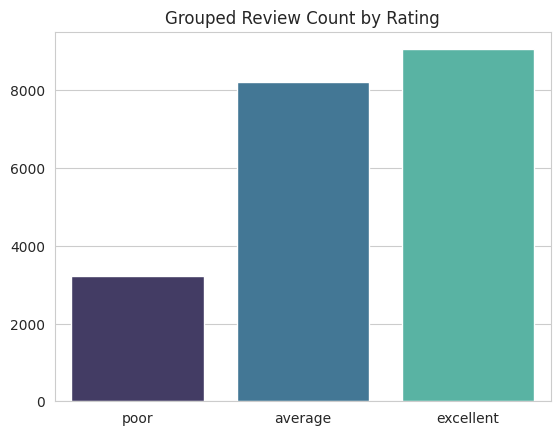

In [11]:
new_rating_grouped = df.groupby('new_rating')['Rating'].count()
new_rating_grouped
ax = sns.barplot(x = ['poor','average','excellent'], y = [3214, 8223, 9054], palette='mako').set_title('Grouped Review Count by Rating')

The class imbalance is less prominent now, but there are still less "poor" review types. This will be accounted for by using the class_weight="balanced" parameter in the models.

**Word Count Graph**

Text(0.5, 1.0, 'Word Count by Review')

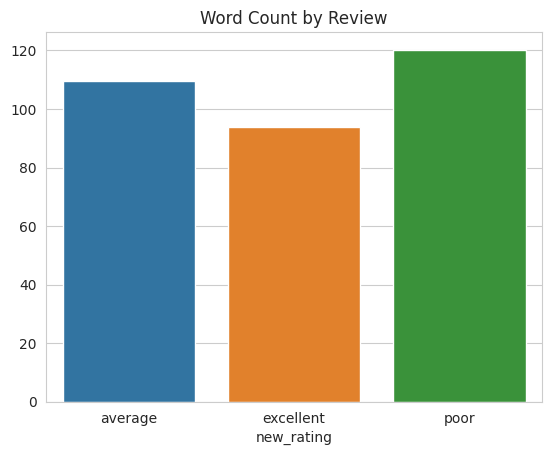

In [12]:
df['words'] = [x.split() for x in df['Review']]
df['word_count'] = [len(x) for x in df['words']]

grouped_rating = df.groupby('new_rating')['word_count'].mean()
sns.barplot(x = grouped_rating.index, y = grouped_rating.values).set_title('Word Count by Review')

This graph shows that the larger the word count, the worse the review. It is worth considering including this feature in the modeling process.

# Preprocessing

Functions will be used on the "Reviews" column in order to prepare the data for modeling.

In [13]:
import nltk

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
sw = stopwords.words('english')

In [15]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [16]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the review corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [17]:
import nltk
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [18]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [19]:
df['tokenized'] = df['Review'].apply(doc_preparer)

In [20]:
df.head()

,Review,Rating,new_rating,words,word_count,tokenized
0,nice hotel expensive parking got good deal sta...,4,average,"[nice, hotel, expensive, parking, got, good, d...",87,nice hotel expensive parking get good deal sta...
1,ok nothing special charge diamond member hilto...,2,poor,"[ok, nothing, special, charge, diamond, member...",250,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,average,"[nice, rooms, not, 4*, experience, hotel, mona...",217,nice room experience hotel monaco seattle good...
3,"unique, great stay, wonderful time hotel monac...",5,excellent,"[unique,, great, stay,, wonderful, time, hotel...",89,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,excellent,"[great, stay, great, stay,, went, seahawk, gam...",191,great stay great stay go seahawk game awesome ...


**# Exploratory Data Analysis Continued**


 Frequency Distribution on Words

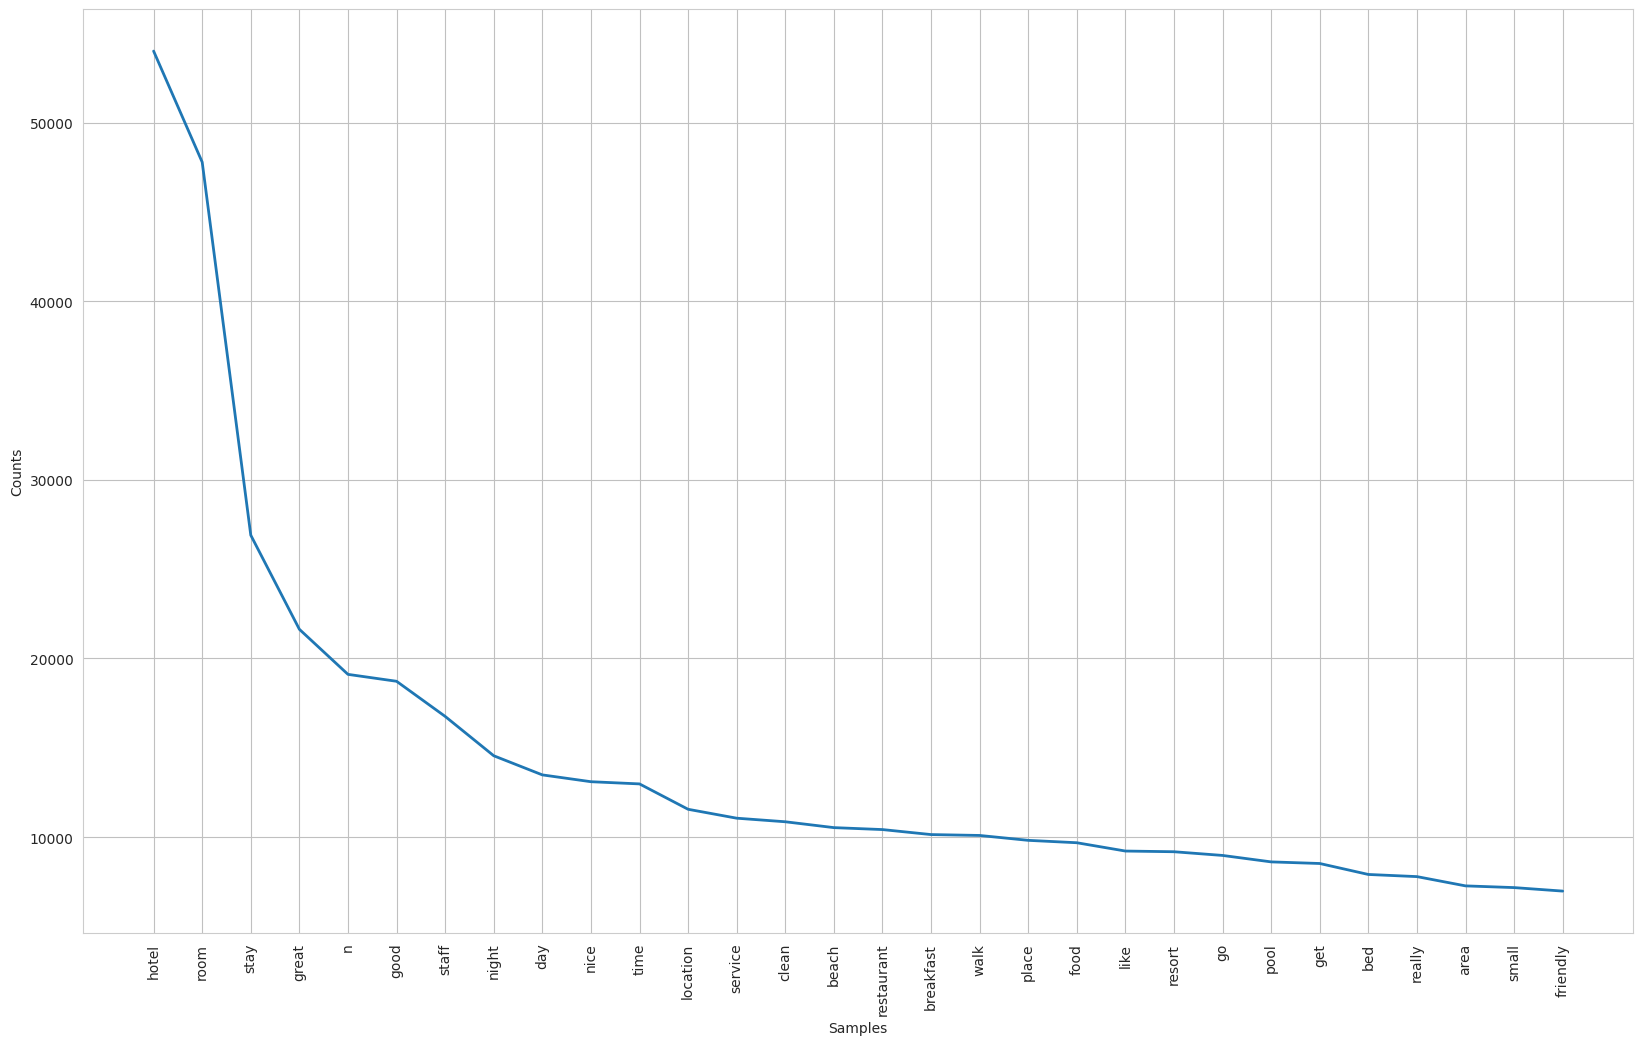

<Axes: xlabel='Samples', ylabel='Counts'>

In [21]:
df['tokenized_words'] = [x.split() for x in df['tokenized']]
tokenized_words = df['tokenized_words'].to_list()

word_list = []
for x in tokenized_words:
    word_list.extend(x)
word_list
freq_dist_text = nltk.FreqDist(word_list)
plt.subplots(figsize=(20,12))
freq_dist_text.plot(30)

This frequency distribution shows which words have a higher frequency in the corpus.

**Word Cloud**

In [22]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

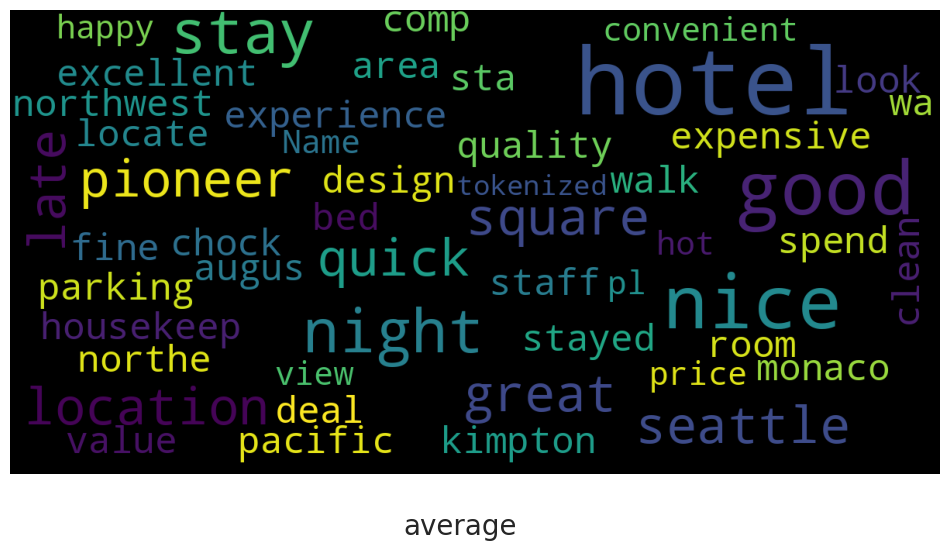

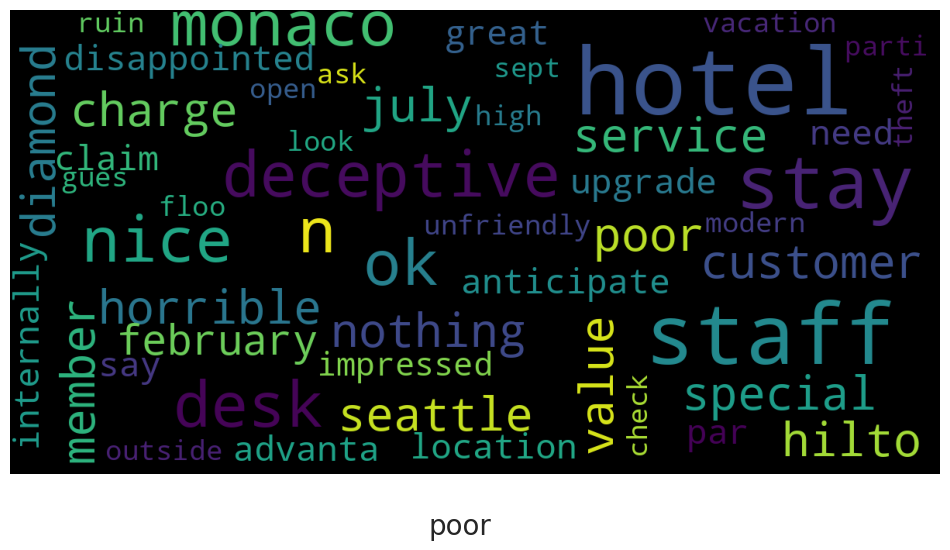

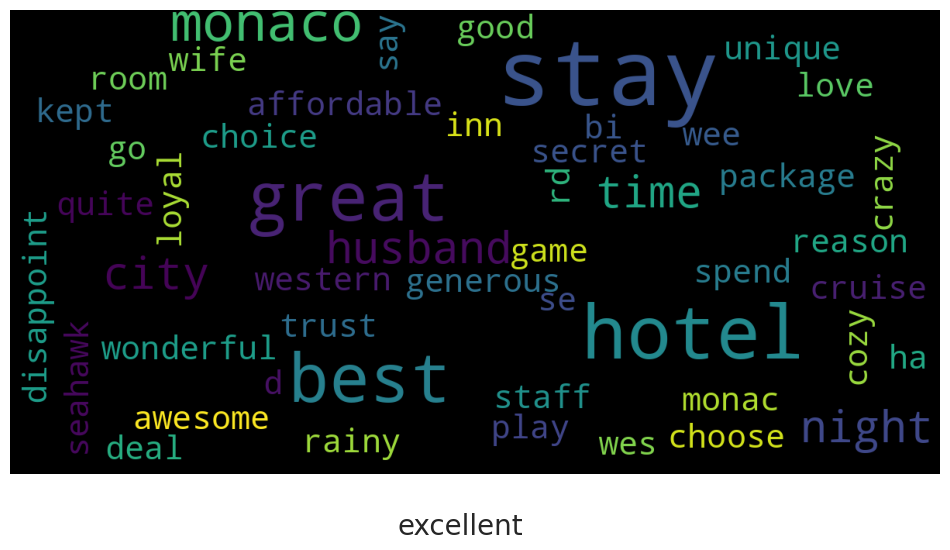

In [23]:
for rating in list(df['new_rating'].unique()):
    show_wordcloud(df[df['new_rating']==rating]['tokenized'], title=rating)

The word clouds above show which words appear most frequently in each category.



# **Part of Speech Violin Plot**

In [24]:
df_eda = pd.DataFrame()
df_eda['LEM']  = df.tokenized
df_eda['POS']  = df.tokenized.apply(lambda x: [pos_tag[1] for pos_tag in pos_tag(word_tokenize(x))] )    #<---pos-tagged tokens ("bag of tags")
df_eda['NOUN'] = df_eda.POS.apply(
    lambda x: sum(1 for pos in x if pos.startswith('NN')) / len(x) if len(x) > 0 else 0)   #<---percentage of nouns
df_eda['ADJ']  = df_eda.POS.apply(
    lambda x: sum(1 for pos in x if pos.startswith('JJ')) / len(x) if len(x) > 0 else 0)   #<---percentage of adjectives
df_eda['ADV']  = df_eda.POS.apply(
    lambda x: sum(1 for pos in x if pos.startswith('RB')) / len(x) if len(x) > 0 else 0)   #<---percentage of adverbs
df_eda['VERB'] = df_eda.POS.apply(
    lambda x: sum(1 for pos in x if pos.startswith('VB')) / len(x) if len(x) > 0 else 0)   #<---percentage of verbs
# structual features
df_eda['CHAR']    = df.Review.apply(lambda x: len(x))             #<---number of characters
df_eda['WORD']    = df.Review.apply(lambda x: len(x.split(' ')))  #<---number of words
df_eda['SENT']    = df.Review.apply(lambda x: len(x.split('. '))) #<---number of sentences
df_eda['LEN']     = df_eda.CHAR / df_eda.WORD                                  #<---average word length
df_eda['AVG']     = df_eda.WORD / df_eda.SENT                                  #<---average sentence length
df_eda['target'] = df['new_rating']

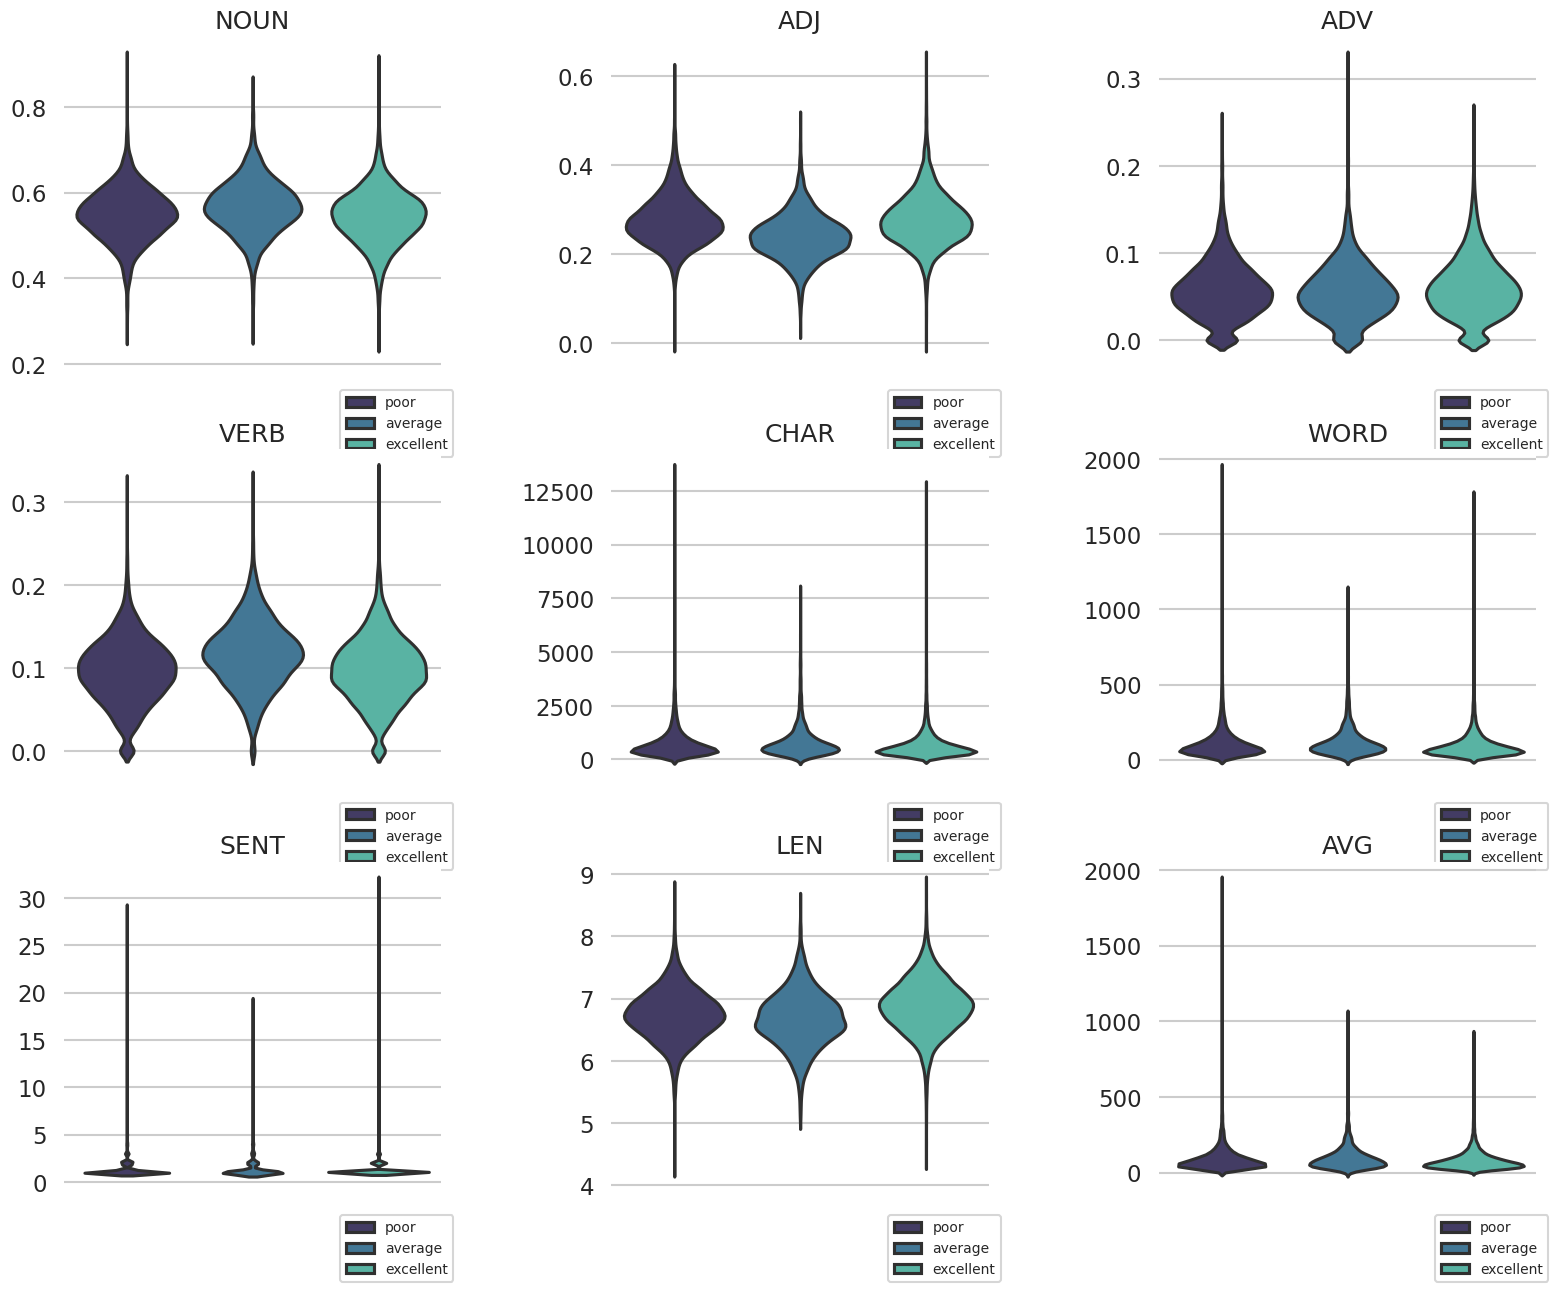

In [25]:
cols = ['TARGET','LEM','NOUN','ADJ','ADV','VERB','CHAR', 'WORD','SENT','LEN','AVG']

# plot feature distributions for helpful and unhelpful reviews
sns.set_style('whitegrid')
sns.set_context("talk")

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(19,15), facecolor='w')
plt.subplots_adjust(wspace=.45, hspace=.25)
sns.despine(bottom = True, left = True)


r = c = 0
for col in cols[2:]:
    sns.violinplot(data=df_eda, y=df_eda[col], x=df_eda.target,
                   ax=ax[r][c], legend_out = True,
                   inner=None, palette='mako').set_title(col)
    
# ax[r][c].set_ylim(ymin=None, ymax=df[col].quantile(.995))
    ax[r][c].set_xticks([])
    ax[r][c].set_xlabel('')
    ax[r][c].set_ylabel('')
    ax[r][c].legend(labels=['poor','average','excellent'], bbox_to_anchor=(1.05, -0.05), prop={'size':10})


    if c < 2:
        c += 1
    else:
        r += 1
        c = 0


# plt.savefig(fname='images/density', bbox_inches='tight', pad_inches=0.1)
plt.show()

#error and how to show legend

The plot above shows the various parts of speech and other review characteristics per each target category. A key takeaway to note, is that the word count, character count, and average length of sentence is higher for 'poor' reviews compared to others.

**Correlation Heatmap**

<ipython-input-26-381f555dd50e>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_eda.corr(),
<ipython-input-26-381f555dd50e>:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask=np.triu(np.ones_like(df_eda.corr(), dtype=bool)),


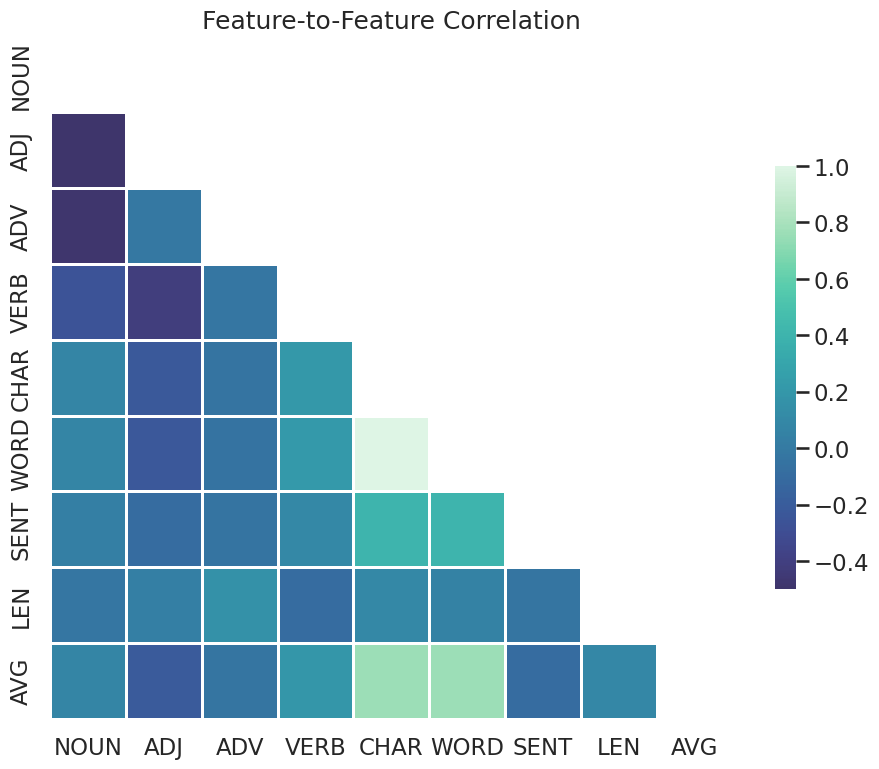

In [26]:
# plot pairwise correlations
sns.set_style('white')
sns.set_palette('dark:salmon')
sns.set_context("talk")

plt.figure(figsize=(11,11), facecolor='w')

sns.heatmap(
    df_eda.corr(),
    mask=np.triu(np.ones_like(df_eda.corr(), dtype=bool)),
    vmin=-0.5, vmax=1, center=0,
    square=True,
    linewidths=1,
    cmap="mako",
    cbar_kws={"shrink": 0.5}).set_title('Feature-to-Feature Correlation')

plt.show()

Based on this feature to feature correlation heatmap, the character count, word count, and average length of sentence have a high correlation to each other.

**Train Test Split**

In [27]:
X = df['tokenized']
y = df['new_rating']

In [28]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, train_size= .8, random_state= 42)

# **Vectorizing**

The TF-IDF Vectorizer is utilized, which takes into account how frequent a word appears in a document and also how unqiue the word is in overall corpus. In order to capture the most meaningful words, we cut off the top 20% and bottom 10% of words in the documents.

In [29]:
tfidf_train = TfidfVectorizer(sublinear_tf=True, max_df=.8, min_df=.10,  ngram_range=(1, 1))

In [30]:
train_features = tfidf_train.fit_transform(X_train).toarray()
test_features = tfidf_train.transform(X_test).toarray()

# **PCA**

We used PCA in order to reduce multidimensionality for some of the models to determine if results would vary.

In [31]:
pca = PCA(n_components=0.9, random_state=1)

pca_train = pca.fit_transform(train_features)
pca_test = pca.transform(test_features)

In [32]:
pca.n_components_

105

**PCA Visual**

In [33]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(train_features)

pca1 = pca_result[:,0]
pca2 = pca_result[:,1] 
pca3 = pca_result[:,2]

target = pd.Categorical(y_train).codes

<ipython-input-34-9ffcd8d4b40e>:11: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
<ipython-input-34-9ffcd8d4b40e>:12: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
<ipython-input-34-9ffcd8d4b40e>:13: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))


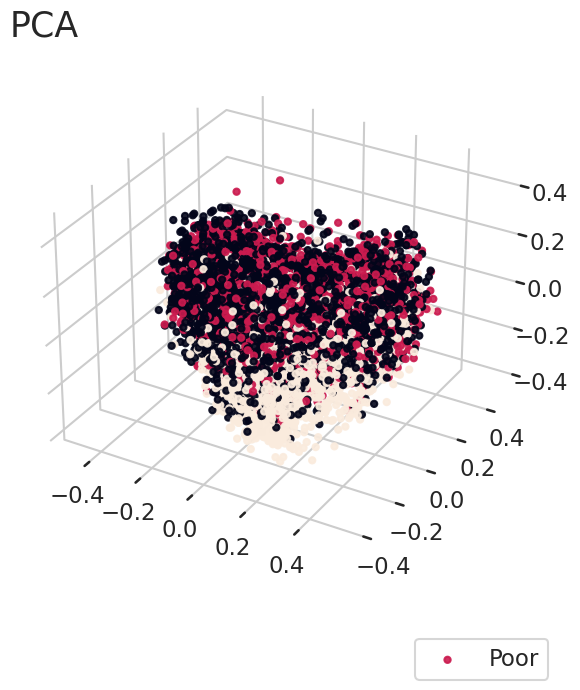

In [34]:
fig = plt.figure(figsize=(19, 7))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_title('PCA', fontsize=25, loc='left')
ax.scatter(xs=pca1, 
           ys=pca2, 
           zs=pca3, 
           c=target,
           alpha=.9,)

ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# ax.legend(['Poor','Average','Excellent'])

ax.legend(['Poor','Average','Excellent'], bbox_to_anchor=(1.02, -0.08))


# **Modeling**



We fit several different models to evaluate the compare which one outputs the highest accuracy & F1 score. In order to accurately compare each model against one another, we performed a grid-search to determine the optimal hyperparameters for each model.

In [35]:
# create function to call for evaluation of each model

def metrics_score(train_preds, y_train, test_preds, y_test):
    print(f"Training Accuracy:\t{accuracy_score(y_train, train_preds):.4}",
          f"\tTesting Accuracy:\t{accuracy_score(y_test, test_preds):.4}")
    print(f"Training Precision:\t{precision_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting Precision:\t{precision_score(y_test, test_preds, average='weighted'):.4}")
    print(f"Training Recall:\t{recall_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting Recall:\t\t{recall_score(y_test, test_preds, average='weighted'):.4}")
    print(f"Training F1:\t\t{f1_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting F1:\t\t{f1_score(y_test, test_preds, average='weighted'):.4}")

**Naive Bayes**

In [36]:
scorer = make_scorer(f1_score, average='weighted')

params=  {'alpha': [0.09, 0.1,0.11]}

nb = MultinomialNB()

grid_search_nb = GridSearchCV(estimator = nb,scoring=scorer, param_grid = params, 
                              cv = 5, n_jobs = -1, verbose = 2)

In [37]:
grid_search_nb.fit(train_features, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.09, 0.1, 0.11]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [38]:
nb_train_preds = grid_search_nb.best_estimator_.predict(train_features)
nb_test_preds = grid_search_nb.best_estimator_.predict(test_features)
metrics_score(nb_train_preds, y_train, nb_test_preds, y_test)

Training Accuracy:	0.6201 	Testing Accuracy:	0.6248
Training Precision:	0.6446 	Testing Precision:	0.6473
Training Recall:	0.6201 	Testing Recall:		0.6248
Training F1:		0.6034 	Testing F1:		0.6045


**`Logisitic Regression`**

In [39]:
#scaling data
ss = StandardScaler()
train_scaled = ss.fit_transform(train_features)
test_scaled = ss.transform(test_features)

In [40]:
# Create regularization hyperparameter space
C = np.logspace(0, 1, 10)

params = dict(C=C, max_iter=[50, 100])

logistic = linear_model.LogisticRegression(penalty='l2', class_weight='balanced', random_state=42)

grid_search_LR = GridSearchCV(estimator = logistic,scoring=scorer, param_grid = params, 
                              cv = 3, n_jobs = -1, verbose = 2)

In [41]:
grid_search_LR.fit(train_scaled, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42),
             n_jobs=-1,
             param_grid={'C': array([ 1.        ,  1.29154967,  1.66810054,  2.15443469,  2.7825594 ,
        3.59381366,  4.64158883,  5.9948425 ,  7.74263683, 10.        ]),
                         'max_iter': [50, 100]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [42]:
lr_train_preds = grid_search_LR.best_estimator_.predict(train_scaled)
lr_test_preds = grid_search_LR.best_estimator_.predict(test_scaled)
metrics_score(lr_train_preds, y_train, lr_test_preds, y_test)

Training Accuracy:	0.6533 	Testing Accuracy:	0.6555
Training Precision:	0.6606 	Testing Precision:	0.6637
Training Recall:	0.6533 	Testing Recall:		0.6555
Training F1:		0.6521 	Testing F1:		0.6539


# **Logisitic Regression with PCA**

In [43]:
# Create regularization hyperparameter space
C = np.logspace(0, 1, 10)

params = dict(C=C, max_iter=[50, 100])

logistic = linear_model.LogisticRegression(penalty='l2', class_weight='balanced', random_state=42)

grid_search_LR_pca = GridSearchCV(estimator = logistic,scoring=scorer, param_grid = params, 
                                  cv = 3, n_jobs = -1, verbose = 2)

In [44]:
grid_search_LR_pca.fit(pca_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42),
             n_jobs=-1,
             param_grid={'C': array([ 1.        ,  1.29154967,  1.66810054,  2.15443469,  2.7825594 ,
        3.59381366,  4.64158883,  5.9948425 ,  7.74263683, 10.        ]),
                         'max_iter': [50, 100]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [45]:
lr_train_preds_pca = grid_search_LR_pca.best_estimator_.predict(pca_train)
lr_test_preds_pca = grid_search_LR_pca.best_estimator_.predict(pca_test)
metrics_score(lr_train_preds_pca, y_train, lr_test_preds_pca, y_test)

Training Accuracy:	0.6477 	Testing Accuracy:	0.6502
Training Precision:	0.6554 	Testing Precision:	0.6588
Training Recall:	0.6477 	Testing Recall:		0.6502
Training F1:		0.6467 	Testing F1:		0.6485


**Decision Tree**

In [46]:
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]

params = dict(criterion=criterion,
                max_depth=max_depth)

DT = tree.DecisionTreeClassifier(criterion =  'gini', max_depth= 10, random_state = 42)

grid_search_DT = GridSearchCV(estimator=DT, param_grid=params, scoring=scorer, 
                              cv = 5, n_jobs = -1, verbose = 2)

In [47]:
grid_search_DT.fit(train_features, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=10, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [48]:
dt_train_preds = grid_search_DT.best_estimator_.predict(train_features)
dt_test_preds = grid_search_DT.best_estimator_.predict(test_features)
metrics_score(dt_train_preds, y_train, dt_test_preds, y_test)

Training Accuracy:	0.7275 	Testing Accuracy:	0.5721
Training Precision:	0.7301 	Testing Precision:	0.5717
Training Recall:	0.7275 	Testing Recall:		0.5721
Training F1:		0.7271 	Testing F1:		0.571


**Decision Tree with PCA**

In [49]:
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]

params = dict(criterion=criterion,
                max_depth=max_depth)

DT = tree.DecisionTreeClassifier(criterion =  'gini', max_depth= 10, random_state = 42)

grid_search_DT_pca = GridSearchCV(estimator=DT, param_grid=params, scoring=scorer, 
                                  cv = 5, n_jobs = -1, verbose = 2)

In [50]:
grid_search_DT_pca.fit(pca_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=10, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [51]:
dt_train_preds_pca = grid_search_DT_pca.best_estimator_.predict(pca_train)
dt_test_preds_pca = grid_search_DT_pca.best_estimator_.predict(pca_test)
metrics_score(dt_train_preds_pca, y_train, dt_test_preds_pca, y_test)

Training Accuracy:	0.6174 	Testing Accuracy:	0.5958
Training Precision:	0.6171 	Testing Precision:	0.5934
Training Recall:	0.6174 	Testing Recall:		0.5958
Training F1:		0.6167 	Testing F1:		0.5936


**Random Forest**

In [52]:
params = { 
    'n_estimators': [200, 500],
    'max_features': ['sqrt'],
    'max_depth' : [4,6,8],
    'criterion' :['gini', 'entropy']
}

rf = RandomForestClassifier(random_state = 42)

grid_search_RF = GridSearchCV(estimator=rf, param_grid=params, scoring=scorer, 
                              cv = 5, n_jobs = -1, verbose = 2)

In [53]:
grid_search_RF.fit(train_features, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8], 'max_features': ['sqrt'],
                         'n_estimators': [200, 500]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [54]:
rf_train_preds = grid_search_RF.best_estimator_.predict(train_features)
rf_test_preds = grid_search_RF.best_estimator_.predict(test_features)
metrics_score(rf_train_preds, y_train, rf_test_preds, y_test)

Training Accuracy:	0.6908 	Testing Accuracy:	0.616
Training Precision:	0.7074 	Testing Precision:	0.6347
Training Recall:	0.6908 	Testing Recall:		0.616
Training F1:		0.6791 	Testing F1:		0.5995


**Light GBM**

In [55]:
lgbm = LGBMClassifier(random_state=42)

param_grid = {'n_estimators': [50, 100],
              'colsample_bytree': [0.7, 0.8],
              'max_depth': [15, 20],
              'num_leaves': [50, 100,],
              'min_split_gain': [0.3,0.4],
              'reg_alpha': [1.0, 1.1],
             'objective': ['multiclass'],
             'num_class':[3],
              'class_label':['weight']
             }

              
grid_lgbm = GridSearchCV(lgbm, param_grid, cv=2, verbose=1, n_jobs=-1)

In [56]:
grid_lgbm.fit(train_features, y_train)

Fitting 2 folds for each of 64 candidates, totalling 128 fits
[LightGBM] [Warning] Unknown parameter: class_label


GridSearchCV(cv=2, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_label': ['weight'],
                         'colsample_bytree': [0.7, 0.8], 'max_depth': [15, 20],
                         'min_split_gain': [0.3, 0.4],
                         'n_estimators': [50, 100], 'num_class': [3],
                         'num_leaves': [50, 100], 'objective': ['multiclass'],
                         'reg_alpha': [1.0, 1.1]},
             verbose=1)

In [57]:
gbm_train_preds = grid_lgbm.best_estimator_.predict(train_features)
gbm_test_preds = grid_lgbm.best_estimator_.predict(test_features)
metrics_score(gbm_train_preds, y_train, gbm_test_preds, y_test)

Training Accuracy:	0.8791 	Testing Accuracy:	0.648
Training Precision:	0.8794 	Testing Precision:	0.647
Training Recall:	0.8791 	Testing Recall:		0.648
Training F1:		0.879 	Testing F1:		0.6454


**KNN**

In [58]:
knn = KNeighborsClassifier()
params = {
    'n_neighbors': [3,5,11,19],
    'weights': ['uniform', 'distance'],
    'metric': ['eucilidean', 'manhattan']
}

grid_knn = GridSearchCV(knn, params, verbose = 1,
                        cv = 3, n_jobs =-1)

In [59]:
grid_knn.fit(train_scaled, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
24 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py", line 213, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/u

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['eucilidean', 'manhattan'],
                         'n_neighbors': [3, 5, 11, 19],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [60]:
knn_train_preds = grid_knn.best_estimator_.predict(train_scaled)
knn_test_preds = grid_knn.best_estimator_.predict(test_scaled)
metrics_score(knn_train_preds, y_train, knn_test_preds, y_test)

Training Accuracy:	0.652 	Testing Accuracy:	0.6016
Training Precision:	0.6608 	Testing Precision:	0.6112
Training Recall:	0.652 	Testing Recall:		0.6016
Training F1:		0.6453 	Testing F1:		0.5922


# Model Evaluation

In [61]:
model_candidates = [
    
    {'name':'Naive Bayes',
     'accuracy score':accuracy_score(y_test, nb_test_preds),
     'f1 score':metrics.f1_score(y_test, nb_test_preds, average='weighted')},
    
    {'name':'Logistic Regression',
     'accuracy score':accuracy_score(y_test, lr_test_preds),
     'f1 score':metrics.f1_score(y_test, lr_test_preds, average='weighted')},
    
    {'name':'Logistic Regression (PCA)',
     'accuracy score':accuracy_score(y_test, lr_test_preds_pca),
    'f1 score':metrics.f1_score(y_test, lr_test_preds_pca, average='weighted')},
    
    {'name':'Decision Tree',
     'accuracy score':accuracy_score(y_test, dt_test_preds),
     'f1 score':metrics.f1_score(y_test, dt_test_preds, average='weighted')},
    
    {'name':'Decision Tree (PCA)',
     'accuracy score':accuracy_score(y_test, dt_test_preds_pca),
     'f1 score':metrics.f1_score(y_test, dt_test_preds_pca, average='weighted')},
    
    {'name':'Random Forest',
     'accuracy score':accuracy_score(y_test, rf_test_preds),
     'f1 score':metrics.f1_score(y_test, rf_test_preds, average='weighted')},
    
    {'name':'Light GBM',
     'accuracy score':accuracy_score(y_test, gbm_test_preds),
     'f1 score':metrics.f1_score(y_test, gbm_test_preds, average='weighted')},
    
    {'name':'KNN',
     'accuracy score':accuracy_score(y_test, knn_test_preds),
      'f1 score':metrics.f1_score(y_test, knn_test_preds, average='weighted')}
 
]

In [62]:
final_scores_df = pd.DataFrame(model_candidates).set_index('name')
final_scores_df

,accuracy score,f1 score
name,,
Naive Bayes,0.624787,0.604537
Logistic Regression,0.655526,0.653858
Logistic Regression (PCA),0.650159,0.648494
Decision Tree,0.572091,0.571000
Decision Tree (PCA),0.595755,0.593609
Random Forest,0.616004,0.599506
Light GBM,0.647963,0.645438
KNN,0.601610,0.592157


The Logistic Regression model has the highest accuracy and F1 score.

**Confusion Matrices for Top 3 Models**

[Text(0, 0.5, 'Average'), Text(0, 1.5, 'Excellent'), Text(0, 2.5, 'Poor')]

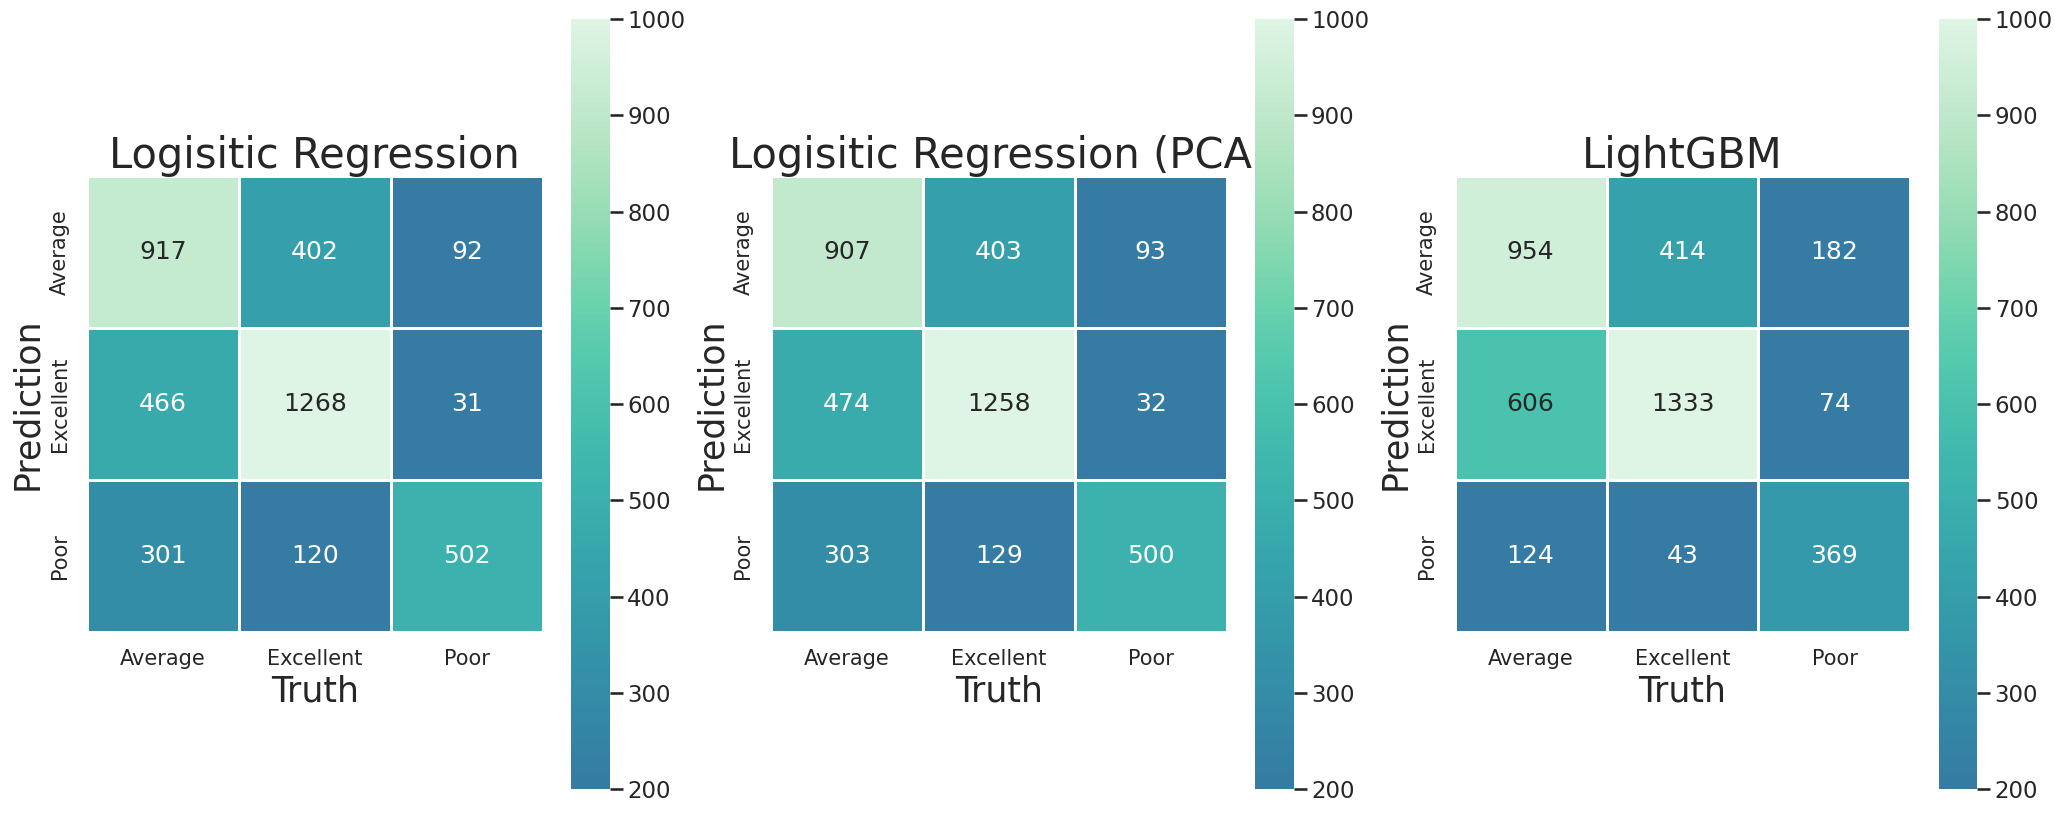

In [63]:
sns.color_palette("viridis", as_cmap=True)
# sns.set_context("talk")

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 10))

# plot logistic regression confusion matrix
sns.heatmap(confusion_matrix(y_test, lr_test_preds).T,
            square=True,
            annot=True,
            fmt='d',
            linewidths=1,
            vmin=200, vmax=1000, center=200,
            cmap="mako",
            ax=ax[0]).set_title('Logisitic Regression', fontsize=30)

ax[0].set_xlabel('Truth', fontsize=25)
ax[0].set_ylabel('Prediction', fontsize=25)
ax[0].set_xticklabels(['Average', 'Excellent', 'Poor'], fontsize=15)
ax[0].set_yticklabels(['Average', 'Excellent', 'Poor'], va='center', fontsize=15)

# plot logistic with PCA confusion matrix
sns.heatmap(confusion_matrix(y_test, lr_test_preds_pca).T,
            square=True,
            annot=True,
            fmt='d',
            linewidths=1,
            vmin=200, vmax=1000, center=200,
            cmap="mako",
            ax=ax[1]).set_title('Logisitic Regression (PCA)', fontsize=30)

ax[1].set_xlabel('Truth', fontsize=25)
ax[1].set_ylabel('Prediction', fontsize=25)
ax[1].set_xticklabels(['Average', 'Excellent', 'Poor'], fontsize=15)
ax[1].set_yticklabels(['Average', 'Excellent', 'Poor'], va='center', fontsize=15)
# plot LightGBM confusion matrix
sns.heatmap(confusion_matrix(y_test, gbm_test_preds).T,
            square=True,
            annot=True,
            fmt='d',
            linewidths=1,
            vmin=200, vmax=1000, center=200,
            cmap="mako",
            ax=ax[2]).set_title('LightGBM', fontsize=30)

ax[2].set_xlabel('Truth', fontsize=25)
ax[2].set_ylabel('Prediction', fontsize=25)
ax[2].set_xticklabels(['Average', 'Excellent', 'Poor'], fontsize=15)
ax[2].set_yticklabels(['Average', 'Excellent', 'Poor'], va='center', fontsize=15)

The logistic regression model did the best at identifying the 'poor' reviews, where 'average' and 'excellent' were relatively similar across the three models. Therefore, the logistic regression model is our final model.